**Filled notebook:**
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/msgtsuzuki/saved_models/blob/main/tutorial03/Tutorial03-N.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/msgtsuzuki/saved_models/blob/main/tutorial03/Tutorial03-N.ipynb)   

#Optimization and Initialization

In this tutorial, techniques for optimization and initialization of neural networks will be reviewed. When increasing the depth of neural networks, various challenges are faced. Most importantly, there is a need to maintain a stable gradient flow through the network, as otherwise issues such as vanishing or exploding gradients may arise. Therefore, a closer examination of the following concepts will be undertaken: initialization and optimization.

In the first half of the notebook, different initialization techniques will be reviewed, progressing step by step from the simplest initialization to methods used in very deep networks today. In the second half, focus will be on optimization, comparing the optimizers SGD, SGD with Momentum, and [Adam](https://arxiv.org/abs/1412.6980).

The process will begin by importing the standard libraries:

In [ ]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy

## Imports for plotting
import matplotlib_inline
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

The same `set_seed` function as in Tutorial 2 will be utilized, along with the path variables `DATASET_PATH` and `CHECKPOINT_PATH`. Adjustments to the paths may be necessary.

In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/tutorial03"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In the final section of the notebook, the models will be trained using three distinct optimizers. The pre-trained models for these optimizers are downloaded below.

In [ ]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial03/"
# Files to download
pretrained_files = ["FashionMNIST_SGD.config",    "FashionMNIST_SGD_results.json",    "FashionMNIST_SGD.tar",
                    "FashionMNIST_SGDMom.config", "FashionMNIST_SGDMom_results.json", "FashionMNIST_SGDMom.tar",
                    "FashionMNIST_Adam.config",   "FashionMNIST_Adam_results.json",   "FashionMNIST_Adam.tar"   ]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

##Preparation

Throughout this notebook, a deep fully connected network will be utilized, akin to the one used in the previous tutorial. The network will once again be applied to FashionMNIST, allowing for comparison with the results of Tutorial 2.
The process begins with the loading of the FashionMNIST dataset.

In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.2861,), (0.3530,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

100%|██████████| 26421880/26421880 [00:08<00:00, 2996543.77it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 143778.01it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2648900.75it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5182975.75it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In contrast to the previous tutorial, adjustments have been made to the parameters of the normalization transformation `transforms.Normalize`. The normalization is currently configured to yield an anticipated mean of 0 and a standard deviation of 1 across pixels. This adjustment is especially pertinent for the forthcoming discussion regarding initialization. It should be emphasized that both normalization techniques (ranging between -1 and 1 or with a mean of 0 and standard deviation of 1) have proven effective in most classification tasks.
The normalization parameters can be calculated by computing the mean and standard deviation on the original images:

In [ ]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.2860405743122101
Std 0.3530242443084717


The transformation can be verified by examining the statistics of a single batch:

In [ ]:
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: 0.020
Standard deviation: 1.011
Maximum: 2.022
Minimum: -0.810


It is noted that the maximum and minimum are no longer 1 and -1, respectively, but shifted towards the positive values. This shift is due to FashionMNIST containing a significant number of black pixels, akin to MNIST.

Next, a linear neural network is created using the same setup as in the previous tutorial.

In [ ]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.ModuleList(layers) # A module list registers a list of modules as submodules (e.g. for parameters)

        self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            x = l(x)
        return x

For the activation functions, the code utilizes PyTorch's `torch.nn` library instead of implementing them manually. However, an `Identity` activation function is also defined. Despite significantly limiting the network's modeling capabilities, it will be employed in the initial stages of the discussion about initialization for the sake of simplicity.

In [ ]:
class Identity(nn.Module):
    def forward(self, x):
        return x

act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "identity": Identity
}

Finally, the code defines a few plotting functions that will be used for discussions. These functions assist in (1) visualizing the weight/parameter distribution inside a network, (2) visualizing the gradients received by the parameters at different layers, and (3) visualizing the activations, which represent the output of the linear layers. The detailed code is not crucial, but interested individuals are encouraged to take a closer look.


In [ ]:
##############################################################

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

##############################################################

def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

##############################################################

def visualize_gradients(model, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels) # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
    model.zero_grad()

    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

##############################################################

def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

##Initialization

Before starting the discussion about initialization, it should be noted that there are many excellent [blog posts](https://www.deeplearning.ai/ai-notes/initialization/) available on the topic of neural network initialization (consider the more math-focused [blog post](https://pouannes.github.io/blog/initialization/#mjx-eqn-eqfwd_K)). In case anything remains unclear after this tutorial, it is recommended to skim through these blog posts as well.

When initializing a neural network, there are several desirable properties. Firstly, the variance of the input should be propagated through the model to the last layer, ensuring a consistent standard deviation for the output neurons. If the variance vanishes as we progress deeper into the model, it becomes challenging to optimize the model, as the input to the next layer effectively becomes a single constant value. Similarly, if the variance increases excessively, it may lead to a gradient explosion, making optimization difficult.

The second property we seek in initialization techniques is a gradient distribution with equal variance across layers. If the first layer receives significantly smaller gradients than the last layer, it becomes difficult to select an appropriate learning rate.

To begin exploring initialization methods, the analysis starts with different initializations based on a linear neural network with no activation function (i.e., an identity). This approach is chosen because initialization methods depend on the specific activation function used in the network, and adjustments can be made to the initialization schemes later for specific choices.

In [ ]:
model = BaseNetwork(act_fn=Identity()).to(device)

##Constant Initialization

The first initialization to consider is initializing all weights with the same constant value. Intuitively, setting all weights to zero is not advisable, as it leads to zero gradients during backpropagation. However, what if we set all weights to a value slightly larger or smaller than 0? To explore this, a function for setting all parameters can be implemented and the gradients visualized.

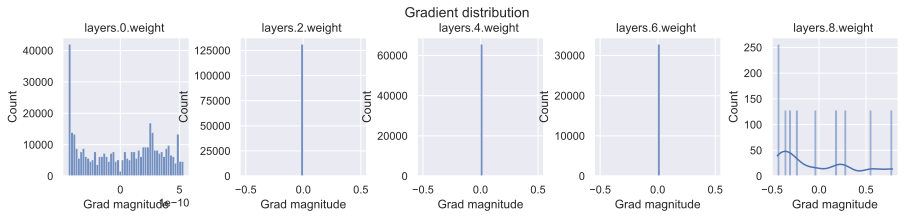

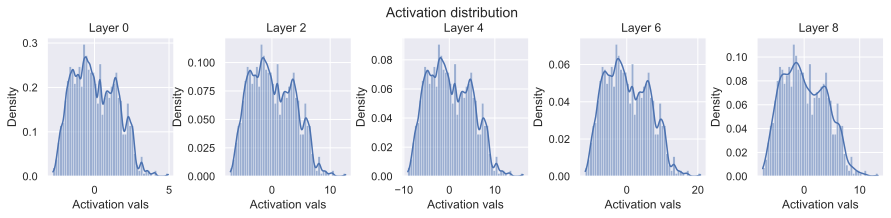

Layer 0 - Variance: 2.0582754611968994
Layer 2 - Variance: 13.489115715026855
Layer 4 - Variance: 22.100555419921875
Layer 6 - Variance: 36.20954132080078
Layer 8 - Variance: 14.831430435180664


In [ ]:
def const_init(model, c=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(c)

const_init(model, c=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

As observed, only the first and last layers exhibit diverse gradient distributions, while the other three layers have identical gradients for all weights (though typically close to zero). Uniform gradients across parameters initialized with the same values imply that these parameters will always maintain the same value. Consequently, this renders the layer ineffective and reduces the effective number of parameters to 1. Thus, constant initialization cannot be used to effectively train our networks.

##Constant Variance

From the experiment above, it is evident that initializing with a constant value is ineffective. Instead, an alternative approach is to initialize the parameters by randomly sampling a distribution such as a Gaussian. The most straightforward method involves choosing a single variance that is applied to all layers in the network. Execute the following method and display the distribution of activations across different layers.

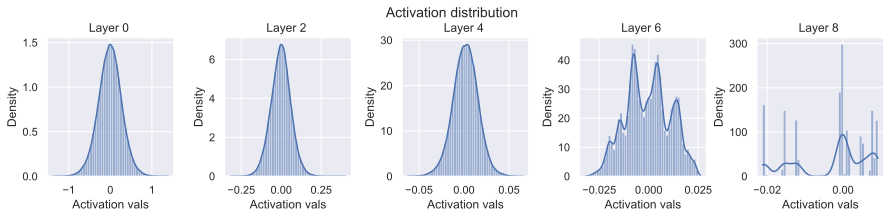

Layer 0 - Variance: 0.07969322800636292
Layer 2 - Variance: 0.003909091465175152
Layer 4 - Variance: 0.0001935981708811596
Layer 6 - Variance: 0.00012434532982297242
Layer 8 - Variance: 9.091599349630997e-05


In [ ]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(std=std)

var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

The variance of the activation decreases progressively across layers, almost vanishing in the last layer. Alternatively, using a higher standard deviation could be considered:

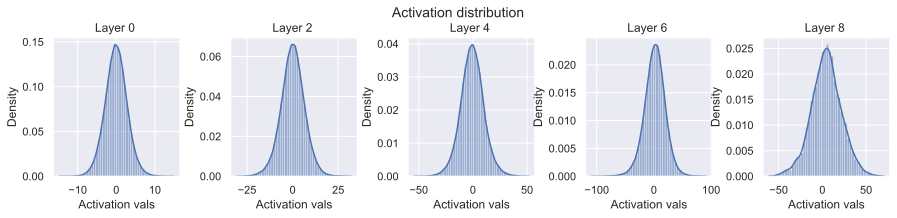

Layer 0 - Variance: 8.15251350402832
Layer 2 - Variance: 41.77054214477539
Layer 4 - Variance: 115.50184631347656
Layer 6 - Variance: 330.7076721191406
Layer 8 - Variance: 302.8797912597656


In [ ]:
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)


With a higher standard deviation, the activations are prone to exploding. One can experiment with specific standard deviation values, but finding one that provides a suitable activation distribution across layers and is tailored to the model can be challenging. Moreover, if there are changes in hidden sizes or the number of layers, one would need to search for optimal values again, which is neither efficient nor recommended.

##How to Find Appropriate Initialization Values

From the experiments carried out above, it is evident that the weights need to be sampled from a distribution, but the exact distribution remains uncertain. As a next step, the goal is to determine the optimal initialization from the perspective of the activation distribution. Two requirements are established for this purpose:

* The mean of the activations should be zero.
*The variance of the activations should remain consistent across every layer.

Suppose that the objective is to design an initialization for the following layer: $ y=Wx+b $ with $ y\in\mathbb{R}^{d_y} $, $ x\in\mathbb{R}^{d_x} $. The aim is to ensure that the variance of each element of $ y $ matches the variance of the input, that is, $ \text{Var}(y_i)=\text{Var}(x_i)=\sigma_x^{2} $, and that the mean is zero. Assuming $ x $ also has a mean of zero, because, in deep neural networks, $ y $ would be the input of another layer, this requires setting the bias $ b $ to zero overall.

Next, the variance with which to initialize the weight parameters must be calculated. During this calculation, the variance rule is utilized: given two independent variables, the variance of their product is $ \text{Var}(X\cdot Y) = \mathbb{E}(Y)^2\text{Var}(X) + \mathbb{E}(X)^2\text{Var}(Y) + \text{Var}(X)\text{Var}(Y) = \mathbb{E}(Y^2)\mathbb{E}(X^2)-\mathbb{E}(Y)^2\mathbb{E}(X)^2 $ ($ X $ and $ Y $ do not refer to $ x $ and $ y $, but to any random variable).

The required variance of the weights, $ \text{Var}(w_{ij}) $, is calculated as follows:

$$
\begin{split}
    y_i & = \sum_{j} w_{ij}x_{j}\hspace{3mm}\text{Calculation of a single output neuron without bias}\\
    \text{Var}(y_i) = \sigma_x^{2} & = \text{Var}\left(\sum_{j} w_{ij}x_{j}\right)\\
    & = \sum_{j} \text{Var}(w_{ij}x_{j}) \hspace{3mm}\text{Inputs and weights are independent of each other}\\
    & = \sum_{j} \text{Var}(w_{ij})\cdot\text{Var}(x_{j}) \hspace{3mm}\text{Variance rule with expectations being zero}\\
    & = d_x \cdot \text{Var}(w_{ij})\cdot\text{Var}(x_{j}) \hspace{3mm}\text{Variance equal for all $ d_x $ elements}\\
    & = \sigma_x^{2} \cdot d_x \cdot \text{Var}(w_{ij})\\
    \Rightarrow \text{Var}(w_{ij}) = \sigma_{W}^2 & = \frac{1}{d_x}\\
\end{split}
$$

Thus, the weight distribution should be initialized with a variance of the inverse of the input dimension $ d_x $. This initialization scheme will be implemented below to verify its effectiveness.

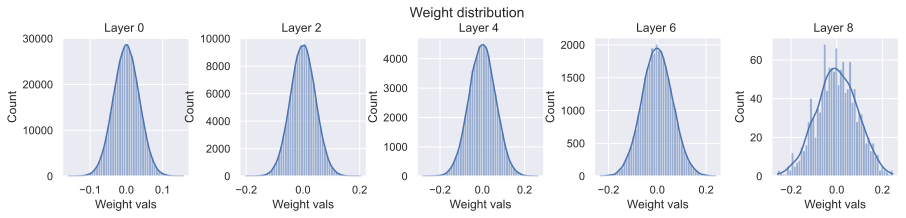

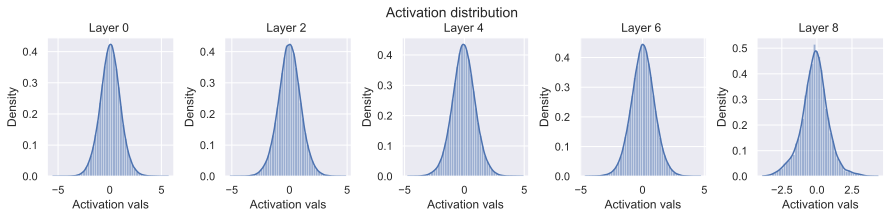

Layer 0 - Variance: 0.9947319030761719
Layer 2 - Variance: 0.9611076712608337
Layer 4 - Variance: 0.9367000460624695
Layer 6 - Variance: 0.9090617895126343
Layer 8 - Variance: 0.944779098033905


In [ ]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0/math.sqrt(param.shape[1]))

equal_var_init(model)
visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)

As expected, the variance remains constant between layers. It is important to note that our initialization method is not limited to a normal distribution, but allows for any distribution with a mean of 0 and a variance of $ \frac{1}{d_x} $. Although a uniform distribution is often used for initialization, one advantage is that it eliminates the possibility of initializing extremely large or small weights.

In addition to stabilizing the variance of activations, another important aspect is stabilizing the variance of gradients, which ensures stable optimization for deep networks. It can be seen that by starting from $ \Delta x=W\Delta y $, similar conclusions can be reached, indicating that the layers should be initialized with $ \frac{1}{d_y} $ where $ d_y $ represents the number of output neurons. This calculation can be practiced or referenced in detail in this [blog post](https://pouannes.github.io/blog/initialization/#mjx-eqn-eqfwd_K). Glorot et al.~\cite{pmlr-v9-glorot10a} proposed a compromise between both constraints, suggesting the use of the harmonic mean of both values, resulting in the well-known Xavier initialization

$$
W\sim \mathcal{N}\left(0,\frac{2}{d_x+d_y}\right).
$$

For a uniform distribution, the weights would be initialized as

$$
 W\sim U\left[-\frac{\sqrt{6}}{\sqrt{d_x+d_y}}, \frac{\sqrt{6}}{\sqrt{d_x+d_y}}\right].
 $$

Implementing this and validating its efficiency.

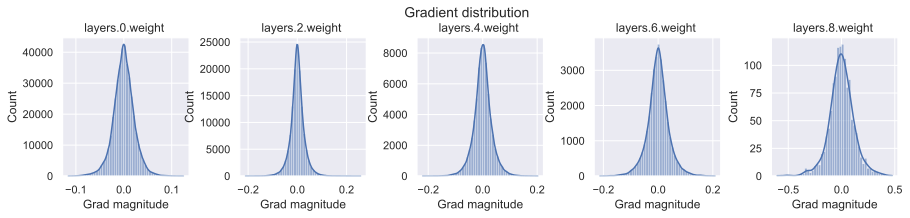

layers.0.weight - Variance: 0.000482581410324201
layers.2.weight - Variance: 0.0008069463074207306
layers.4.weight - Variance: 0.0010949688730761409
layers.6.weight - Variance: 0.0015486852498725057
layers.8.weight - Variance: 0.01409720629453659


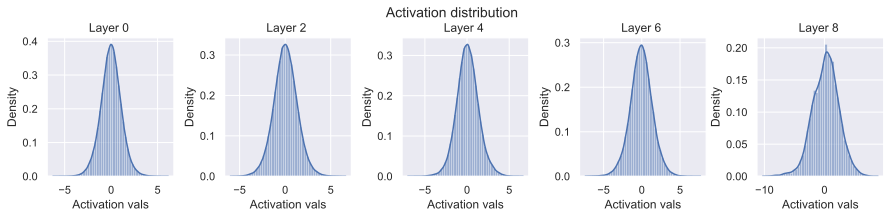

Layer 0 - Variance: 1.2188551425933838
Layer 2 - Variance: 1.6798386573791504
Layer 4 - Variance: 1.6837313175201416
Layer 6 - Variance: 2.124478340148926
Layer 8 - Variance: 4.800870895385742


In [ ]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6)/math.sqrt(param.shape[0]+param.shape[1])
            param.data.uniform_(-bound, bound)

xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

They see that Xavier initialization balances the variance of gradients and activations. Note that the significantly higher variance for the output layer is due to the large difference in input and output dimensions (128 vs. 10). However, they currently assume the activation function to be linear. So what happens if a nonlinearity is added? In a tanh-based network, a common assumption is that for small values during the initial training steps, $\tanh$ works as a linear function so that there is no need to adjust their calculation. They can check if that is the case for them as well:

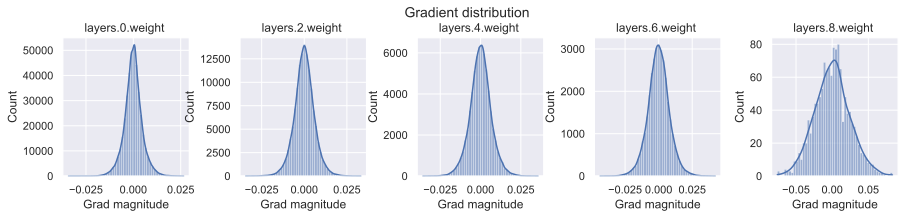

layers.0.weight - Variance: 2.2186170099303126e-05
layers.2.weight - Variance: 3.4413191315252334e-05
layers.4.weight - Variance: 4.287606498110108e-05
layers.6.weight - Variance: 6.369704351527616e-05
layers.8.weight - Variance: 0.0005942207062616944


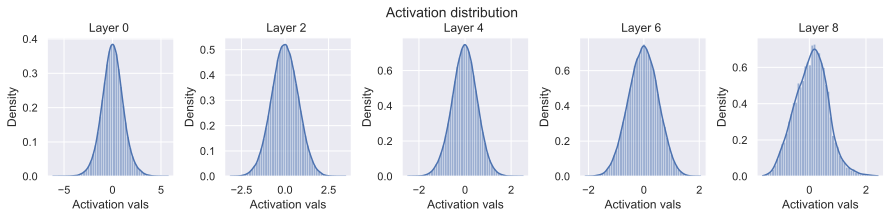

Layer 0 - Variance: 1.2355849742889404
Layer 2 - Variance: 0.5790526270866394
Layer 4 - Variance: 0.29683613777160645
Layer 6 - Variance: 0.28346267342567444
Layer 8 - Variance: 0.336361825466156


In [ ]:
model = BaseNetwork(act_fn=nn.Tanh()).to(device)
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)


Although the variance decreases with depth, it is evident that the activation distribution becomes more concentrated on lower values. Consequently, if one were to further deepen the network, the variance would stabilize around 0.25. This observation suggests that the Xavier initialization performs effectively for Tanh networks. However, what about ReLU networks?

In ReLU networks, one cannot apply the previous assumption that the non-linearity becomes linear for small values. The ReLU activation function sets (in expectation) half of the inputs to 0, which means that the expectation of the input is not zero. However, as long as the expectation of $W$ is zero and $b=0$, the expectation of the output remains zero. The difference in calculating the ReLU initialization from the identity lies in determining $\text{Var}(w_{ij}x_{j})$:

$$
\text{Var}(w_{ij}x_{j})=\underbrace{\mathbb{E}[w_{ij}^2]}_{=\text{Var}(w_{ij})}\mathbb{E}[x_{j}^2]-\underbrace{\mathbb{E}[w_{ij}]^2}_{=0}\mathbb{E}[x_{j}]^2=\text{Var}(w_{ij})\mathbb{E}[x_{j}^2]
$$

Assuming $x$ is the result of a ReLU activation (from a previous layer, $x=\max(0,\tilde{y})$), one can calculate the expectation as follows:

$$
\begin{split}
    \mathbb{E}[x^2] & =\mathbb{E}[\max(0,\tilde{y})^2]\\
                    & =\frac{1}{2}\mathbb{E}[{\tilde{y}}^2]\hspace{2cm}\tilde{y}\text{ is zero-centered and symmetric}\\
                    & =\frac{1}{2}\text{Var}(\tilde{y})
\end{split}
$$

Thus, an additional factor of $1/2$ is observed in the equation, resulting in the desired weight variance of $2/d_x$. This gives rise to the [Kaiming initialization](https://www.cv-foundation.org/openaccess/content_iccv_2015/html/He_Delving_Deep_into_ICCV_2015_paper.html). Note that the Kaiming initialization does not utilize the harmonic mean between the input and output sizes. In their [paper](https://arxiv.org/pdf/1502.01852.pdf), (Section 2.2, Backward Propagation, last paragraph).}, He, K. et al. argue that using $d_x$ or $d_y$ both leads to stable gradients throughout the network and depend solely on the overall input size of the network. Therefore, only the input $d_x$ is used.


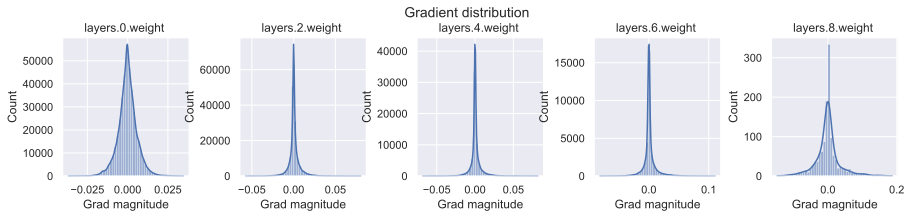

layers.0.weight - Variance: 3.4263281122548506e-05
layers.2.weight - Variance: 4.246120442985557e-05
layers.4.weight - Variance: 4.685096791945398e-05
layers.6.weight - Variance: 0.00011238642036914825
layers.8.weight - Variance: 0.0013458672910928726


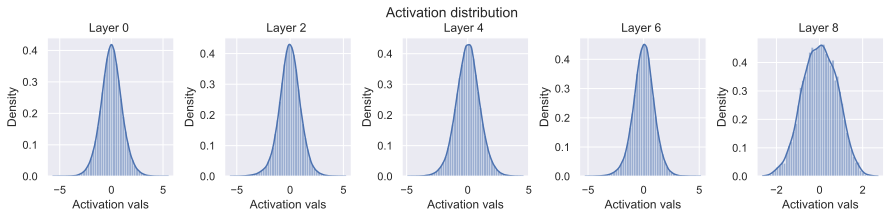

Layer 0 - Variance: 1.0569161176681519
Layer 2 - Variance: 1.0373319387435913
Layer 4 - Variance: 0.9507238864898682
Layer 6 - Variance: 0.918834924697876
Layer 8 - Variance: 0.6361695528030396


In [ ]:
def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"): # The first layer does not have ReLU applied on its input
            param.data.normal_(0, 1/math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2)/math.sqrt(param.shape[1]))

model = BaseNetwork(act_fn=nn.ReLU()).to(device)
kaiming_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)


The variance remains stable across layers. It can be concluded that the Kaiming initialization indeed works well for ReLU-based networks. It should be noted that for Leaky-ReLU, etc., a slight adjustment to the factor of $2$ in the variance is required, as half of the values are no longer set to zero. PyTorch provides a function to calculate this factor for many activation functions, see [`torch.nn.init.calculate_gain`](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain).

##Optimization

In addition to initialization, selecting a suitable optimization algorithm can be an important choice for deep neural networks. Before taking a closer look at them, it is necessary to define a code for training the models. Most of the following code is copied from the previous tutorial and only slightly altered to fit the current needs.

In [ ]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")

def load_model(model_path, model_name, net=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        assert act_fn_name in act_fn_by_name, f"Unknown activation function \"{act_fn_name}\". Please add it to the \"act_fn_by_name\" dict."
        act_fn = act_fn_by_name[act_fn_name]()
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file))
    return net

def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

def train_model(net, model_name, optim_func, max_epochs=50, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print(f"Model file of \"{model_name}\" already exists. Skipping training...")
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "r") as f:
            results = json.load(f)
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer =  optim_func(net.parameters())
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        results = None
        val_scores = []
        train_losses, train_scores = [], []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            t = tqdm(train_loader_local, leave=False)
            for imgs, labels in t:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum().item()
                count += labels.shape[0]
                t.set_description(f"Epoch {epoch+1}: loss={loss.item():4.2f}")
                train_losses.append(loss.item())
            train_acc = true_preds / count
            train_scores.append(train_acc)

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch

    if results is None:
        load_model(CHECKPOINT_PATH, model_name, net=net)
        test_acc = test_model(net, test_loader)
        results = {"test_acc": test_acc, "val_scores": val_scores, "train_losses": train_losses, "train_scores": train_scores}
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "w") as f:
            json.dump(results, f)

    # Plot a curve of the validation accuracy
    sns.set()
    plt.plot([i for i in range(1,len(results["train_scores"])+1)], results["train_scores"], label="Train")
    plt.plot([i for i in range(1,len(results["val_scores"])+1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.ylim(min(results["val_scores"]), max(results["train_scores"])*1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()

    print((f" Test accuracy: {results['test_acc']*100.0:4.2f}% ").center(50, "=")+"\n")
    return results


def test_model(net, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

First, it is necessary to understand what an optimizer actually does. The optimizer is responsible for updating the network's parameters given the gradients. Hence, effectively implementing a function $w^{t} = f(w^{t-1}, g^{t}, ...)$ with $w$ being the parameters and $g^{t} = \nabla_{w^{(t-1)}} \mathcal{L}^{(t)}$ the gradients at the time step $t$. A common additional parameter to this function is the learning rate, denoted here by $\eta$. Usually, the learning rate can be seen as the "step size" of the update. A higher learning rate means that the weights change more in the direction of the gradients, while a smaller learning rate means shorter steps.

As most optimizers only differ in the implementation of $f$, a template for an optimizer in PyTorch can be defined below. It takes as input the parameters of a model and a learning rate. The function
`zero_grad` sets the gradients of all parameters to zero, which must be done before calling
`loss.backward()`. Finally, the
`step()` function tells the optimizer to update all weights based on their gradients. The template is set up below:

In [ ]:
class OptimizerTemplate:

    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        ## Set gradients of all parameters to zero
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # For second-order optimizers important
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        ## Apply update step to all parameters
        for p in self.params:
            if p.grad is None: # We skip parameters without any gradients
                continue
            self.update_param(p)

    def update_param(self, p):
        # To be implemented in optimizer-specific classes
        raise NotImplementedError

The first optimizer to be implemented is the standard [Stochastic Gradient Descent (SGD)](https://arxiv.org/abs/1609.04747). SGD updates the parameters using

$$
\begin{split}
    w^{(t)} & = w^{(t-1)} - \eta \cdot g^{(t)}.
\end{split}
$$

The implementation of SGD is also straightforward.


In [ ]:
class SGD(OptimizerTemplate):

    def __init__(self, params, lr):
        super().__init__(params, lr)

    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update) # In-place update => saves memory and does not create computation graph

The concept of momentum was previously discussed, which replaces the gradient in the update by an exponential average of all past gradients, as in

$$
\begin{split}
    m^{(t)} & = \beta_1 m^{(t-1)} + (1 - \beta_1)\cdot g^{(t)}\\
    w^{(t)} & = w^{(t-1)} - \eta \cdot m^{(t)}.
\end{split}
$$

Below is the implementation.

In [ ]:
class SGDMomentum(OptimizerTemplate):

    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.momentum = momentum # Corresponds to beta_1 in the equation above
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params} # Dict to store m_t

    def update_param(self, p):
        self.param_momentum[p] = (1 - self.momentum) * p.grad + self.momentum * self.param_momentum[p]
        p_update = -self.lr * self.param_momentum[p]
        p.add_(p_update)

Finally, the discussion gets to Adam. Adam combines the idea of [momentum with an adaptive learning rate](https://proceedings.neurips.cc/paper_files/paper/2017/file/81b3833e2504647f9d794f7d7b9bf341-Paper.pdf), which is based on an exponential average of the squared gradients, that is, the gradient norm. Furthermore, a bias correction for the momentum and adaptive learning rate for the first iterations is added, as

$$
\begin{split}
    m^{(t)} & = \beta_1 m^{(t-1)} + (1 - \beta_1)\cdot g^{(t)}\\
    v^{(t)} & = \beta_2 v^{(t-1)} + (1 - \beta_2)\cdot \left(g^{(t)}\right)^2\\
    \hat{m}^{(t)} & = \frac{m^{(t)}}{1-\beta^{t}_1}, \hat{v}^{(t)} = \frac{v^{(t)}}{1-\beta^{t}_2}\\
    w^{(t)} & = w^{(t-1)} - \frac{\eta}{\sqrt{\hat{v}^{(t)}} + \epsilon}\circ \hat{m}^{(t)}.
\end{split}
$$

Here, the epsilon is a small constant used to improve the numerical stability for very small gradient norms. It is important to remember that the adaptive learning rate does not replace the learning rate hyperparameter $\eta$, but rather acts as an extra factor to ensure that the gradients of various parameters have a similar norm.

In [ ]:
class Adam(OptimizerTemplate):

    def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.param_step = {p: 0 for p in self.params} # Remembers "t" for each parameter for bias correction
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.param_step[p] += 1

        self.param_momentum[p] = (1 - self.beta1) * p.grad + self.beta1 * self.param_momentum[p]
        self.param_2nd_momentum[p] = (1 - self.beta2) * (p.grad)**2 + self.beta2 * self.param_2nd_momentum[p]

        bias_correction_1 = 1 - self.beta1 ** self.param_step[p]
        bias_correction_2 = 1 - self.beta2 ** self.param_step[p]

        p_2nd_mom = self.param_2nd_momentum[p] / bias_correction_2
        p_mom = self.param_momentum[p] / bias_correction_1
        p_lr = self.lr / (torch.sqrt(p_2nd_mom) + self.eps)
        p_update = -p_lr * p_mom

        p.add_(p_update)

##Comparing Optimizers on Model Training

After implementing three optimizers (SGD, SGD with momentum, and Adam), the analysis and comparison of these methods can begin. First, they are tested for their ability to optimize a neural network on the FashionMNIST dataset. A linear network with ReLU activation and Kaiming initialization is utilized for this task, as it has been found to work effectively for ReLU-based networks in previous experiments. It is noted that the model is over-parameterized for this task, and similar performance can be achieved with a much smaller network (for example, `100,100,100`). However, the primary focus lies in evaluating how well optimizers can train *deep neural* networks, hence the deliberate overparameterization.

In [ ]:
base_model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=[512,256,256,128])
kaiming_init(base_model)

For a fair comparison, the exact same model is trained with the same seed using the three optimizers below. Users are welcome to adjust the hyperparameters if desired, although they must train their own model in that case.

Model file of "FashionMNIST_SGD" already exists. Skipping training...


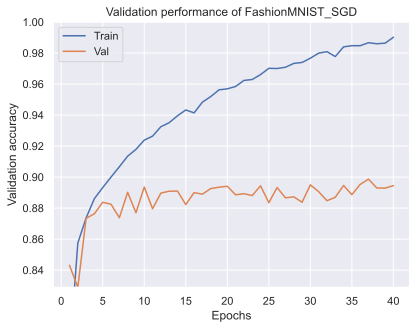

============= Test accuracy: 89.09% ==============



In [ ]:
SGD_model = copy.deepcopy(base_model).to(device)
SGD_results = train_model(SGD_model, "FashionMNIST_SGD",
                          lambda params: SGD(params, lr=1e-1),
                          max_epochs=40, batch_size=256)

Model file of "FashionMNIST_SGDMom" already exists. Skipping training...


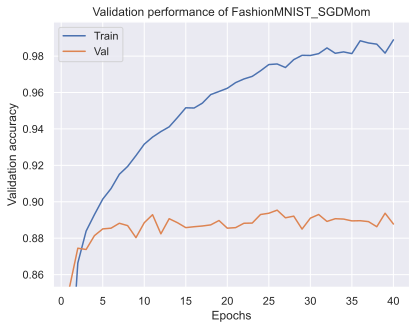

============= Test accuracy: 88.83% ==============



In [ ]:
SGDMom_model = copy.deepcopy(base_model).to(device)
SGDMom_results = train_model(SGDMom_model, "FashionMNIST_SGDMom",
                             lambda params: SGDMomentum(params, lr=1e-1, momentum=0.9),
                             max_epochs=40, batch_size=256)

Model file of "FashionMNIST_Adam" already exists. Skipping training...


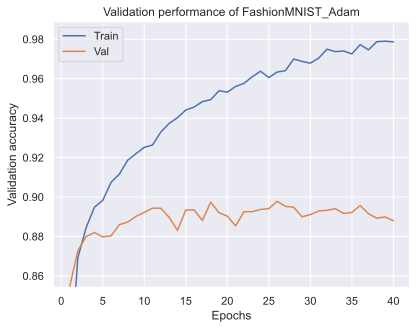

============= Test accuracy: 89.46% ==============



In [ ]:
Adam_model = copy.deepcopy(base_model).to(device)
Adam_results = train_model(Adam_model, "FashionMNIST_Adam",
                           lambda params: Adam(params, lr=1e-3),
                           max_epochs=40, batch_size=256)

The results indicate that all optimizers perform similarly well with the given model. Differences are too marginal to draw any significant conclusions. However, it should be noted that this outcome may also be influenced by the initialization method chosen. When switching to a less effective initialization method (such as constant initialization), Adam typically demonstrates greater robustness due to its adaptive learning rate. To highlight the specific advantages of each optimizer, a further detailed examination of potential loss surfaces will be conducted where momentum and adaptive learning rate play crucial roles.

##Pathological Curvatures

Pathological curvature is a type of surface that is similar to ravines and is particularly tricky for simple SGD optimization. In words, pathological curvatures typically have a steep gradient in one direction with an optimum at the center, while in a second direction, we have a slower gradient towards a (global) optimum. First, an example surface of this will be created and visualized:

In [ ]:
def pathological_curve_loss(w1, w2):
    # Example of a pathological curvature. There are many more possible, feel free to experiment here!
    x1_loss = torch.tanh(w1)**2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

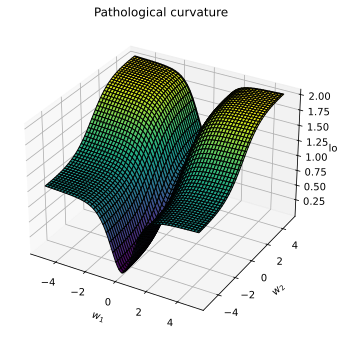

In [ ]:
def plot_curve(curve_fn, x_range=(-5,5), y_range=(-5,5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"):
    fig = plt.figure()
    ax = plt.axes(projection='3d') if plot_3d else plt.axes()

    x = torch.arange(x_range[0], x_range[1], (x_range[1]-x_range[0])/100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/100.)
    x, y = torch.meshgrid(x, y, indexing='xy')
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()

    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In terms of optimization, $w_1$ and $w_2$ represent weight parameters, and the curvature represents the loss surface over the space of $w_1$ and $w_2$. Note that in typical networks, there are many more parameters than two, and such curvatures can occur in multi-dimensional spaces as well.

Ideally, the optimization algorithm would find the center of the ravine and focus on optimizing the parameters in the direction of $w_2$. However, if a point along the ridges is encountered, the gradient is much higher in $w_1$ than in $w_2$, and it might jump from one side to the other. Due to the large gradients, the learning rate would have to be reduced, significantly slowing down learning.

To test the algorithms, a simple function can be implemented to train two parameters on such a surface:

In [ ]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5,5]):
    """
    Inputs:
        optimizer_func - Constructor of the optimizer to use. Should only take a parameter list
        curve_func - Loss function (e.g. pathological curvature)
        num_updates - Number of updates/steps to take when optimizing
        init - Initial values of parameters. Must be a list/tuple with two elements representing w_1 and w_2
    Outputs:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optimizer = optimizer_func([weights])

    list_points = []
    for _ in range(num_updates):
        loss = curve_func(weights[0], weights[1])
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    points = torch.stack(list_points, dim=0).numpy()
    return points

Next, the different optimizers will be applied to the curvature. Note that a much higher learning rate is set for optimization algorithms compared to what would be used in a standard neural network. This is because there are only 2 parameters instead of tens of thousands or even millions.

In [ ]:
SGD_points = train_curve(lambda params: SGD(params, lr=10))
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=10, momentum=0.9))
Adam_points = train_curve(lambda params: Adam(params, lr=1))

To understand better how the different algorithms worked, the update step is visualized as a line plot through the loss surface. A 2D representation is used for readability.

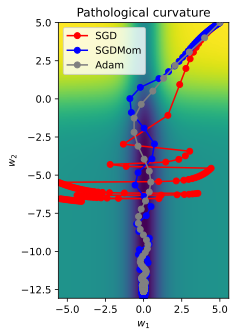

In [ ]:
all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(pathological_curve_loss,
                x_range=(-np.absolute(all_points[:,0]).max(), np.absolute(all_points[:,0]).max()),
                y_range=(all_points[:,1].min(), all_points[:,1].max()),
                plot_3d=False)
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=1, label="SGD")
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom")
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=3, label="Adam")
plt.legend()
plt.show()

It is clear that SGD is not able to find the center of the optimization curve and has a problem converging due to the steep gradients in $w_1$. In contrast, Adam and SGD with momentum nicely converge as the changing direction of $w_1$ cancels itself out. On such surfaces, it is crucial to use momentum.

##Steep Optima

Another type of challenging loss surfaces is steep optima. In these, a larger part of the surface exhibits very small gradients, while around the optimum, the gradients are very large. For instance, consider the following loss surfaces:

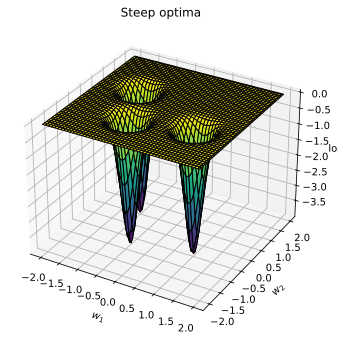

In [ ]:
def bivar_gaussian(w1, w2, x_mean=0.0, y_mean=0.0, x_sig=1.0, y_sig=1.0):
    norm = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * (w1 - x_mean)**2) / (2 * x_sig**2)
    y_exp = (-1 * (w2 - y_mean)**2) / (2 * y_sig**2)
    return norm * torch.exp(x_exp + y_exp)

def comb_func(w1, w2):
    z = -bivar_gaussian(w1, w2, x_mean=1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-1.0, y_mean=0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)
    return z

_ = plot_curve(comb_func, x_range=(-2,2), y_range=(-2,2), plot_3d=True, title="Steep optima")

Most of the loss surface exhibits very little to no gradients. However, near the optima, we encounter very steep gradients. To reach the minimum when starting in a region with lower gradients, an adaptive learning rate is expected to be crucial. To verify this hypothesis, the three optimizers can be run on the surface:

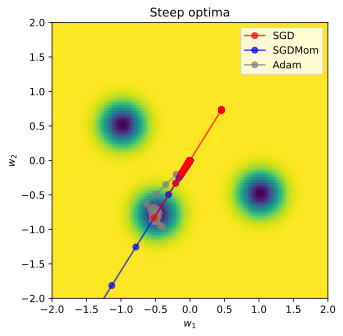

In [ ]:
SGD_points = train_curve(lambda params: SGD(params, lr=.5), comb_func, init=[0,0])
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=1, momentum=0.9), comb_func, init=[0,0])
Adam_points = train_curve(lambda params: Adam(params, lr=0.2), comb_func, init=[0,0])

all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(comb_func,
                x_range=(-2, 2),
                y_range=(-2, 2),
                plot_3d=False,
                title="Steep optima")
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=3, label="SGD", alpha=0.7)
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom", alpha=0.7)
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=1, label="Adam", alpha=0.7)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.legend()
plt.show()

SGD initially takes very small steps until it reaches the optimum border. After reaching a point around $(-0.75,-0.5)$, the direction of the gradient changes, pushing the parameters to $(0.8,0.5)$, from which SGD struggles to recover (requiring many steps). The momentum-bound SGD encounters a similar issue, but it continues in the direction of the touch of the optimum. However, the gradients at this time step are much larger than at any other point, overpowering the momentum $m_t$. On the contrary, Adam is able to converge to the optimum, highlighting the importance of adaptive learning rates.

##What Optimizer to Take?

After observing the optimization results, what conclusions can be drawn? Should Adam be used exclusively, with no consideration for SGD? The short answer is no. Several articles suggest that in certain scenarios, SGD (with momentum) leads to better generalization, whereas [Adam often tends to overfit](https://arxiv.org/pdf/1609.04836.pdf). This is related to the concept of finding wider optima. For example, consider the illustration of different optima shown [below](https://arxiv.org/abs/1609.04836).

<center style="width: 100%"><img src="https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial03/flat_vs_sharp_minima.svg" width="600px"></center>


In this illustration, the black line represents the training loss surface, while the dotted red line represents the test loss. Discovering sharp and narrow minima may help to achieve the minimum training loss. However, this does not necessarily translate to minimizing the test loss, as flat minima have demonstrated better generalization. One can envision that the test dataset's loss surface is slightly shifted due to the different examples compared to the training set. A minor alteration can significantly affect sharp minima, whereas flat minima are generally more resilient to such changes.

In the following tutorial, it will be shown that some network architectures can still gain advantages from using stochastic gradient descent (SGD) with learning rate adjustments instead of Adam. Despite this, Adam continues to be the most widely utilized optimizer in the field of Deep Learning due to its usual superior performance compared to other optimizers, particularly for deep neural networks.

##Conclusion

In this tutorial, various initialization and optimization techniques for neural networks have been explored. Effective initialization has been observed to strike a balance between preserving gradient variance and activation variance. This balance is achieved with the Xavier initialization for tanh-based networks and the Kaiming initialization for ReLU-based networks. Regarding optimization, concepts such as momentum and adaptive learning rate can help navigate challenging loss surfaces, although they do not guarantee improved performance for neural networks.